# Model Refinement by Class Histogram - Selectivity | Histogram per Pixel

In this experiment, we will evaluate if it is possible to reduce the size of layers in a trained model without losing significant performance. For this to be possible, we need to identify the neurons that are more relevant to the model's performance. We do it as follows:
* First we calculate the class histogram of every position (pixel) in the activation of each kernel in a particular layer. The class histogram has C bins (C is the number of classes) and each bin is measured as Np(c) - Nz(c), where Np(c) is the number of images which produce positive activation in that position (pixel) and Nz(c) is the number of images producing non-positive activations in that position (pixel).
* We remove class histograms that do not respect one of two thresholds:
    * They have more than T2% of bins with positive size.
    * They have all bins with non-positive size.
* We cluster the class histograms belonging to each kernel, in order to retrieve C representative histograms.
* We project the n_kernels x C histograms to 2-D using t-sne.
* The user selects a group of histograms to be kept in the model while the others are removed. We calculate whether the chosen neurons cover all the images in the training set (i.e., every image activates positive values for at least one neuron).
* We check the performance of the model after removal.
* We freeze all layers in the model until the modified layer and we train the model to check if it is able to acquire an equal or improved performance from the original model.

In [1]:
import numpy as np
import importlib
import random
import json

import auxiliar_functions as af

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from matplotlib.colorbar import ColorbarBase

from keras.datasets import cifar10
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from keras.utils import np_utils
from keras.optimizers import SGD

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

from mpl_toolkits.axes_grid1 import make_axes_locatable

Using TensorFlow backend.


In [50]:
importlib.reload(af);

In [3]:
# Set random seed for reproducibility.
np.random.seed(0)
random.seed(0)

# Download CIFAR dataset.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
 
# Normalize images.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
 
# One hot code labels.
num_classes = np.unique(y_train).shape[0]
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

# Shape of each observation.
elem_shape = x_train.shape[1:]

# Dataset labels.
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

## Model

In this experiment, we use a model with 6 conv layers, achieving about 80% test set accuracy. We test each class histogram technique in both the first and last convolutional layer, so we can discover if the class histograms behave differently in deeper layers or not.

In [4]:
# Load pre-trained model.
model = load_model('models/model7.49.h5')

# Display model architecture.
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_67 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_54 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 8, 8, 64)          0         
__________

In [5]:
# Get predictions for the train set.
p_labels = np.argmax(model.predict(x_train), axis=1)
t_labels = np.argmax(y_train, axis=1)

# Check accuracy.
scores = model.evaluate(x_test, y_test, verbose=2)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 80.54%


## 1st Layer Analysis

We first calculate the class histograms and the selectivity vector of each pixel position in the layer.

In [6]:
histograms, selectivity = af.class_histogram_conv2d_v3(model, 0, x_train, t_labels, p_labels, num_classes)

We also create a matrix mapping each training set image to the kernels that activate for that image in at least one pixel. This will be important in order to make sure we select kernels covering all training examples.

In [7]:
actv_matrix = af.activation_matrix_conv2d(model, 0, x_train, t_labels, p_labels, num_classes)    

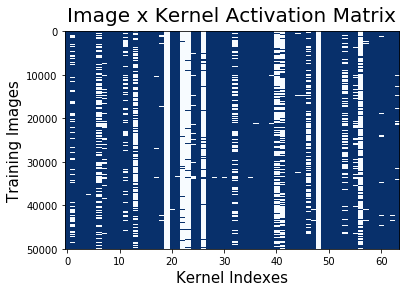

0

In [8]:
af.plot_activation_matrix(actv_matrix)

All training elements activated in at least one kernel.

In [9]:
histograms.shape, selectivity.shape

((64, 32, 32, 10), (64, 32, 32, 10))

Currently, we have 1024 class histograms per kernel, which results in 65536 histograms in total. Projecting all of them at once would be computationally expensive. It would be visually overwhelming and hard for the user to understand as well.

To fix this, we will apply clustering to reduce the number of datapoints we visualize. The clustering has to be restrict to positions from the same kernel, as we still want to visualize datapoints that are kernel-specific.

In [10]:
histograms = af.merge_pixels_dim(histograms)
selectivity = af.merge_pixels_dim(selectivity)

In [11]:
histograms.shape, selectivity.shape

((64, 1024, 10), (64, 1024, 10))

We also calculate the selectivity intensity (SI) of each kernel. The SI of a given position is the bin of max value subtracted by the bin of min value. The SI of each kernel is the max SI for any position of said kernel.

In [12]:
si_max, si_mean = af.selectivity_intensity(selectivity)
si_max.shape, si_mean.shape

((64,), (64,))

Clustering each kernel's positions...

In [13]:
h, s = af.cluster_histograms(histograms, selectivity, 10)

In [14]:
h.shape, s.shape

((64, 10, 10), (64, 10, 10))

We merge all resulting class histograms in a single bidimensional matrix. This is needed to easily visualize them and remove undesirable positions. However, we also keep the kernel id of each position so we know from which kernel is that position from.

In [15]:
id_array = af.kernel_id_array(h)

In [16]:
h = af.merge_array_dim(h)
s = af.merge_array_dim(s)

In [17]:
h.shape, s.shape, id_array.shape

((640, 10), (640, 10), (640,))

Now, lets remove all class histograms which are outside our two thresholds:
* T1: Drop all positions which the class histograms has all bins below a threshold t1.
* T2: Drop all positions which the class histogram has more than t2% of the bins with positive values.

First, we will set t1 to 0.0 and t2 to 1.0. As the first layer is likely to not be very distinguishable regarding the classes, it is better to keep kernels that are activating a lot. However, we can remove those which all classes have small predominance (i.e., the position do not activate for the majority of images from any given class)

In [32]:
h1, s1, m1, k1 = af.remove_histograms_by_selectivity(0.0, 1.0, h, s, actv_matrix, id_array, num_classes)

In [33]:
h1.shape, s1.shape, k1.shape, m1.shape

((147, 10), (147, 10), (147,), (50000, 50))

In [34]:
np.unique(k1), np.unique(k1).shape

(array([ 0,  2,  3,  4,  5,  7,  8,  9, 10, 12, 13, 14, 15, 16, 17, 18, 20,
        21, 24, 25, 27, 28, 29, 30, 31, 33, 34, 35, 36, 37, 38, 39, 42, 43,
        44, 45, 47, 49, 50, 51, 52, 54, 55, 57, 58, 59, 60, 61, 62, 63]),
 (50,))

After clustering and removing class histograms outside our thresholds, we reduce the number of interesting positions from originally 65536 to only 61 positions. This also decreased the number of kernels in our layer from 64 to 50.

Now we build a new model without the dropped units in the first layer and check its performance.

In [35]:
n_model = af.reduce_model_units(model, 0, np.unique(k1))

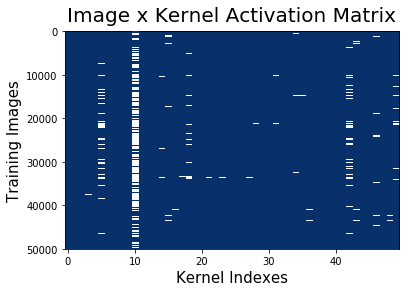

0

In [386]:
af.plot_activation_matrix(m1)

In [37]:
scores = n_model.evaluate(x_test, y_test, verbose=2)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 80.55%


The accuracy did not decrease at all. Furthemore, all training elements continue to be covered by the kernels left. This validates our assumption that the dropped kernels were not helping the network.

Now we are going to project all class histograms in order to visualize if they form clusters of redundant positions/kernels.

In [38]:
proj, div = af.project_histogram(h1, p=30, e=12.0, l=200.0)
div

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 147 samples in 0.000s...
[t-SNE] Computed neighbors for 147 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 147 / 147
[t-SNE] Mean sigma: 740.597310
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.747711
[t-SNE] Error after 1000 iterations: 0.234286


0.23428572714328766

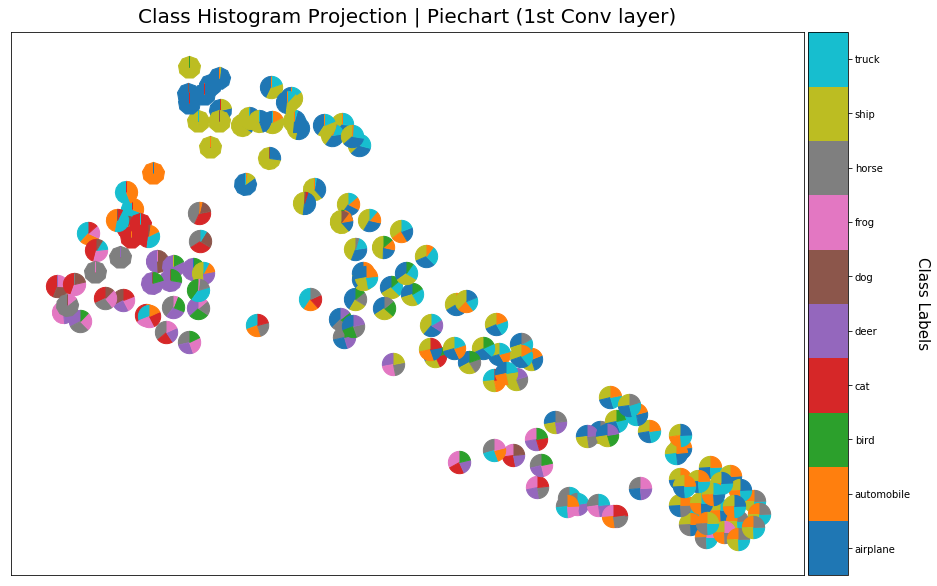

In [39]:
af.plot_projection_piechart(proj, h1, 4, labels, '1st Conv', -1, 500)

Before saving the data, we order the histograms using hierarchical clustering and we sort bins by size

In [40]:
h1.shape, s1.shape, k1.shape, proj.shape

((147, 10), (147, 10), (147,), (147, 2))

In [41]:
h1, s1, k1, proj = af.sort_histograms(h1, s1, k1, proj)

In [54]:
h1.shape, s1.shape, k1.shape, proj.shape

((147, 10), (147, 10), (147,), (147, 2))

In [55]:
h1, s1, o1 = af.sort_bins(h1, s1)

In [58]:
h1.shape, s1.shape, o1.shape

((147, 10), (147, 10), (147, 10))

We save the model in order to visualize it using d3js. I chose it instead of matplotlib because it can create better interactions.

In [59]:
data = {
    'histograms': h1.tolist(),
    'selectivity': s1.tolist(),
    'actv_matrix': m1.tolist(),
    'id_array': k1.tolist(),
    'bin_order': o1.tolist(),
    'projection': proj.tolist(),
    'intensity_max': si_max.tolist(),
    'intensity_mean': si_mean.tolist()
}

with open('refinement_v2/layer1.json', 'w') as fp:
    json.dump(data, fp)

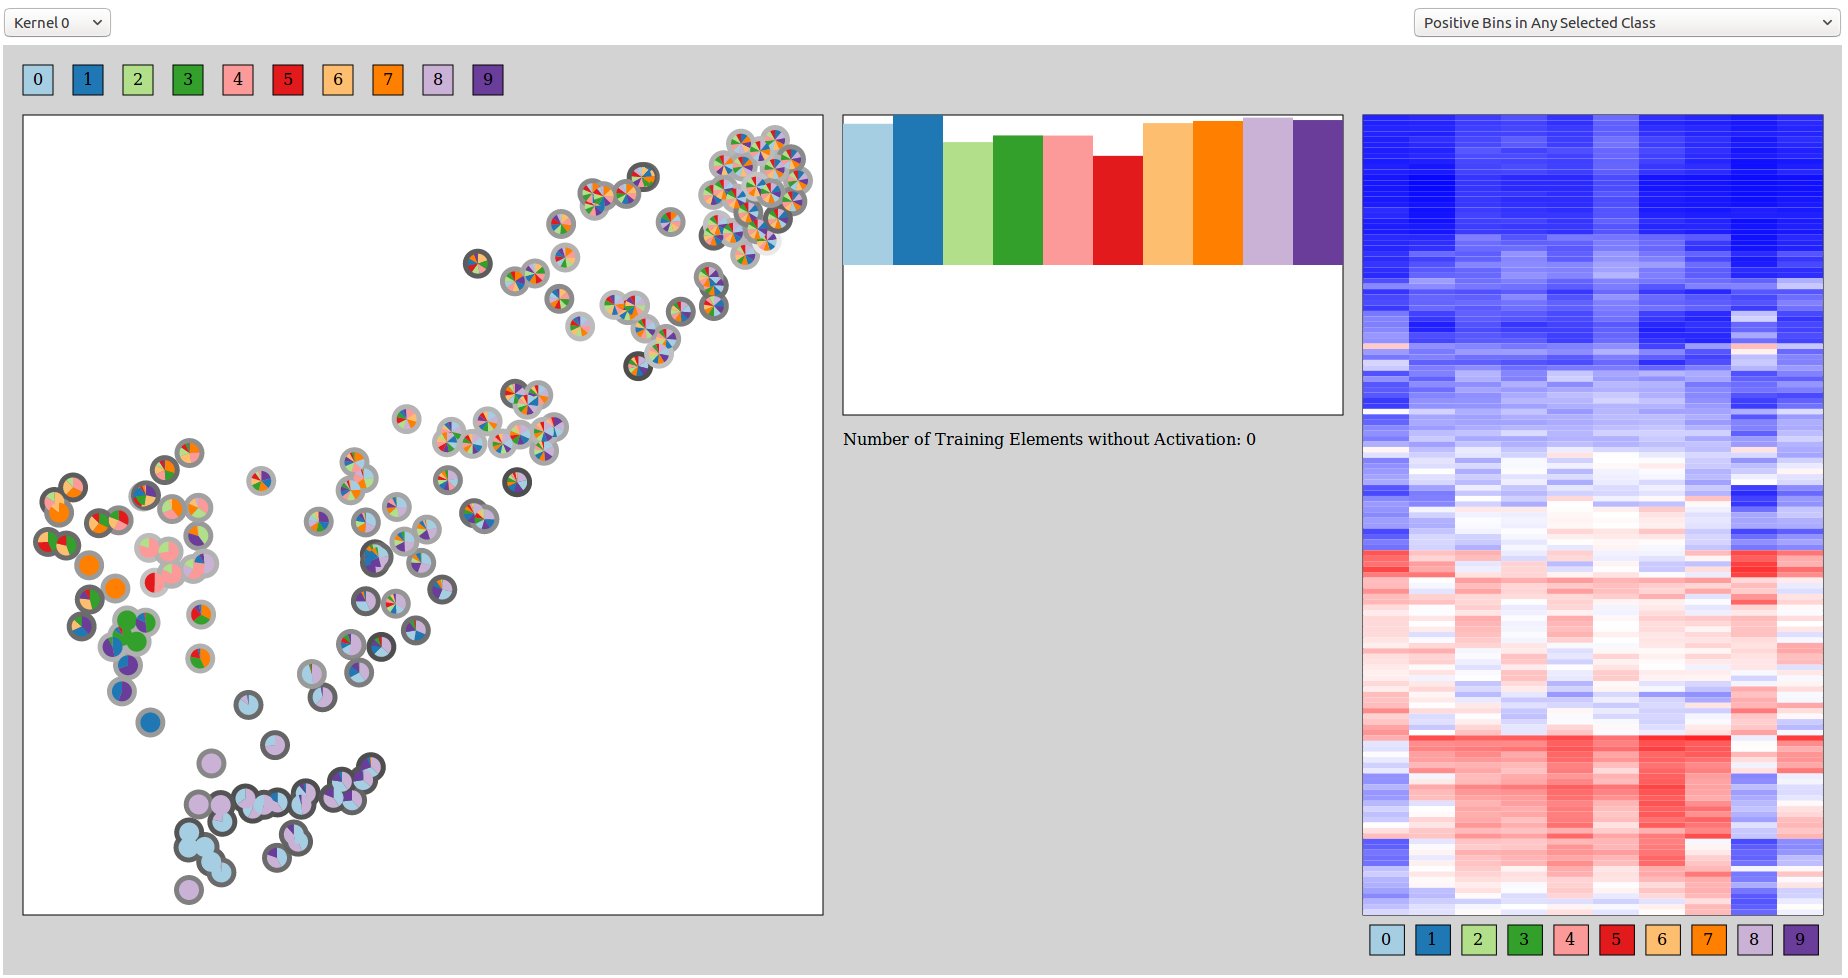

### Manual dropping.

Based on the visualization we will remove the following neurons.

In [382]:
kernels = np.unique(k1)
indexes = np.array([i for i in range(kernels.shape[0])])
dropped = [2, 4, 7, 10, 12, 13, 14, 16, 17, 18, 20, 21, 24, 25, 28, 35, 39, 43, 55, 58, 59, 60, 63]
drop_id = np.array([np.where(kernels == x)[0][0] for x in dropped])
drop_kn = np.delete(indexes, drop_id)

kernels, indexes, drop_id, drop_kn

(array([ 0,  2,  3,  4,  5,  7,  8,  9, 10, 12, 13, 14, 15, 16, 17, 18, 20,
        21, 24, 25, 27, 28, 29, 30, 31, 33, 34, 35, 36, 37, 38, 39, 42, 43,
        44, 45, 47, 49, 50, 51, 52, 54, 55, 57, 58, 59, 60, 61, 62, 63]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 array([ 1,  3,  5,  8,  9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 21, 27, 31,
        33, 42, 44, 45, 46, 49]),
 array([ 0,  2,  4,  6,  7, 12, 20, 22, 23, 24, 25, 26, 28, 29, 30, 32, 34,
        35, 36, 37, 38, 39, 40, 41, 43, 47, 48]))

In [383]:
n_model2 = af.reduce_model_units(n_model, 0, drop_kn)

In [384]:
scores = n_model2.evaluate(x_test, y_test, verbose=2)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 80.55%


In [385]:
n_model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_363 (Conv2D)          (None, 32, 32, 27)        756       
_________________________________________________________________
conv2d_364 (Conv2D)          (None, 32, 32, 64)        15616     
_________________________________________________________________
max_pooling2d_181 (MaxPoolin (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_241 (Dropout)        (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_365 (Conv2D)          (None, 16, 16, 64)        36928     
_________________________________________________________________
conv2d_366 (Conv2D)          (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_182 (MaxPoolin (None, 8, 8, 64)          0         
__________

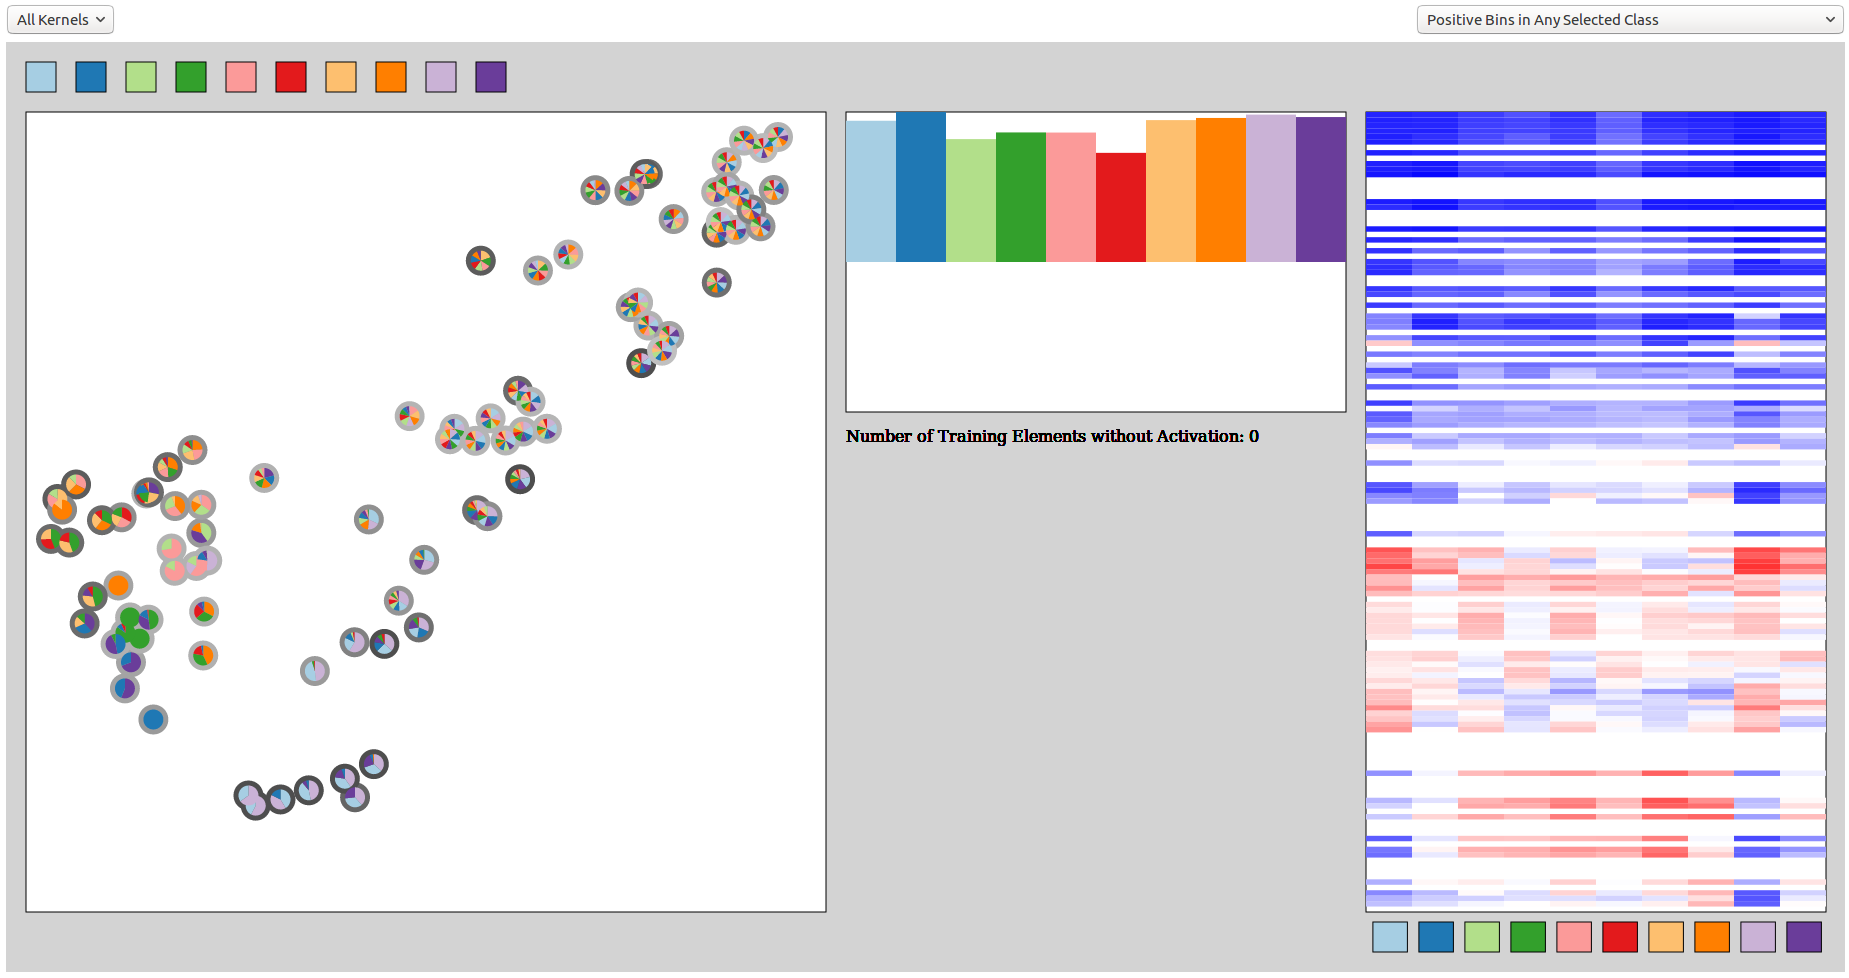

### Brute-Force Search

I will do a small experiment where I will loop through all 64 neurons in the original model's first layer, remove them each-at-once and check the performance. Afterwards I will remove all of the neurons that do not decrease performance when dropped.
* This way I can check if removing all of them at once does not decrease performance too. Maybe if two neurons have redundant jobs, you can remove any of them but not both.
* I can look for a better pattern to decide which neurons should be dropped.

In [393]:
idx = np.array([i for i in range(model.layers[0].output_shape[-1])])
pfm = np.zeros((model.layers[0].output_shape[-1],))

for i in range(model.layers[0].output_shape[-1]):
    krn = np.delete(idx, [i])
    n_modelBF = af.reduce_model_units(model, 0, krn)
    
    scores = n_modelBF.evaluate(x_test, y_test, verbose=2)
    print("Accuracy: %.2f%%" % (scores[1]*100))
    pfm[i] = scores[1]*100

Accuracy: 79.11%
Accuracy: 80.55%
Accuracy: 80.55%
Accuracy: 80.38%
Accuracy: 80.62%
Accuracy: 80.53%
Accuracy: 80.55%
Accuracy: 80.64%
Accuracy: 80.52%
Accuracy: 80.56%
Accuracy: 80.47%
Accuracy: 80.57%
Accuracy: 80.69%
Accuracy: 80.56%
Accuracy: 80.51%
Accuracy: 80.58%
Accuracy: 80.82%
Accuracy: 80.54%
Accuracy: 80.55%
Accuracy: 80.54%
Accuracy: 80.62%
Accuracy: 80.57%
Accuracy: 80.54%
Accuracy: 80.54%
Accuracy: 80.58%
Accuracy: 80.64%
Accuracy: 80.54%
Accuracy: 79.80%
Accuracy: 80.59%
Accuracy: 80.37%
Accuracy: 79.91%
Accuracy: 80.59%
Accuracy: 80.55%
Accuracy: 79.32%
Accuracy: 80.42%
Accuracy: 80.54%
Accuracy: 80.56%
Accuracy: 80.39%
Accuracy: 80.51%
Accuracy: 80.72%
Accuracy: 80.53%
Accuracy: 80.54%
Accuracy: 80.60%
Accuracy: 80.71%
Accuracy: 80.68%
Accuracy: 80.83%
Accuracy: 80.56%
Accuracy: 80.49%
Accuracy: 80.54%
Accuracy: 80.03%
Accuracy: 80.66%
Accuracy: 80.45%
Accuracy: 79.22%
Accuracy: 80.56%
Accuracy: 80.32%
Accuracy: 80.58%
Accuracy: 80.54%
Accuracy: 80.49%
Accuracy: 80.5

In [395]:
data = { 'performances': pfm.tolist() }

with open('refinement_v2/layer1_performance.json', 'w') as fp:
    json.dump(data, fp)

In [438]:
idx2 = idx[pfm < 80.54]
idx, pfm, idx2, idx2.shape

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]),
 array([79.11, 80.55, 80.55, 80.38, 80.62, 80.53, 80.55, 80.64, 80.52,
        80.56, 80.47, 80.57, 80.69, 80.56, 80.51, 80.58, 80.82, 80.54,
        80.55, 80.54, 80.62, 80.57, 80.54, 80.54, 80.58, 80.64, 80.54,
        79.8 , 80.59, 80.37, 79.91, 80.59, 80.55, 79.32, 80.42, 80.54,
        80.56, 80.39, 80.51, 80.72, 80.53, 80.54, 80.6 , 80.71, 80.68,
        80.83, 80.56, 80.49, 80.54, 80.03, 80.66, 80.45, 79.22, 80.56,
        80.32, 80.58, 80.54, 80.49, 80.55, 80.49, 80.6 , 80.57, 80.39,
        80.61]),
 array([ 0,  3,  5,  8, 10, 14, 27, 29, 30, 33, 34, 37, 38, 40, 47, 49, 51,
        52, 54, 57, 59, 62]),
 (22,))

In [439]:
n_modelBF = af.reduce_model_units(model, 0, idx2)

In [440]:
scores = n_modelBF.evaluate(x_test, y_test, verbose=2)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 79.98%


If we remove all neurons that do not decrease performance, we just get a very small decrease in the performance (0.6%). So our assumption of redundant neurons is true, though it does not have a huge impact.

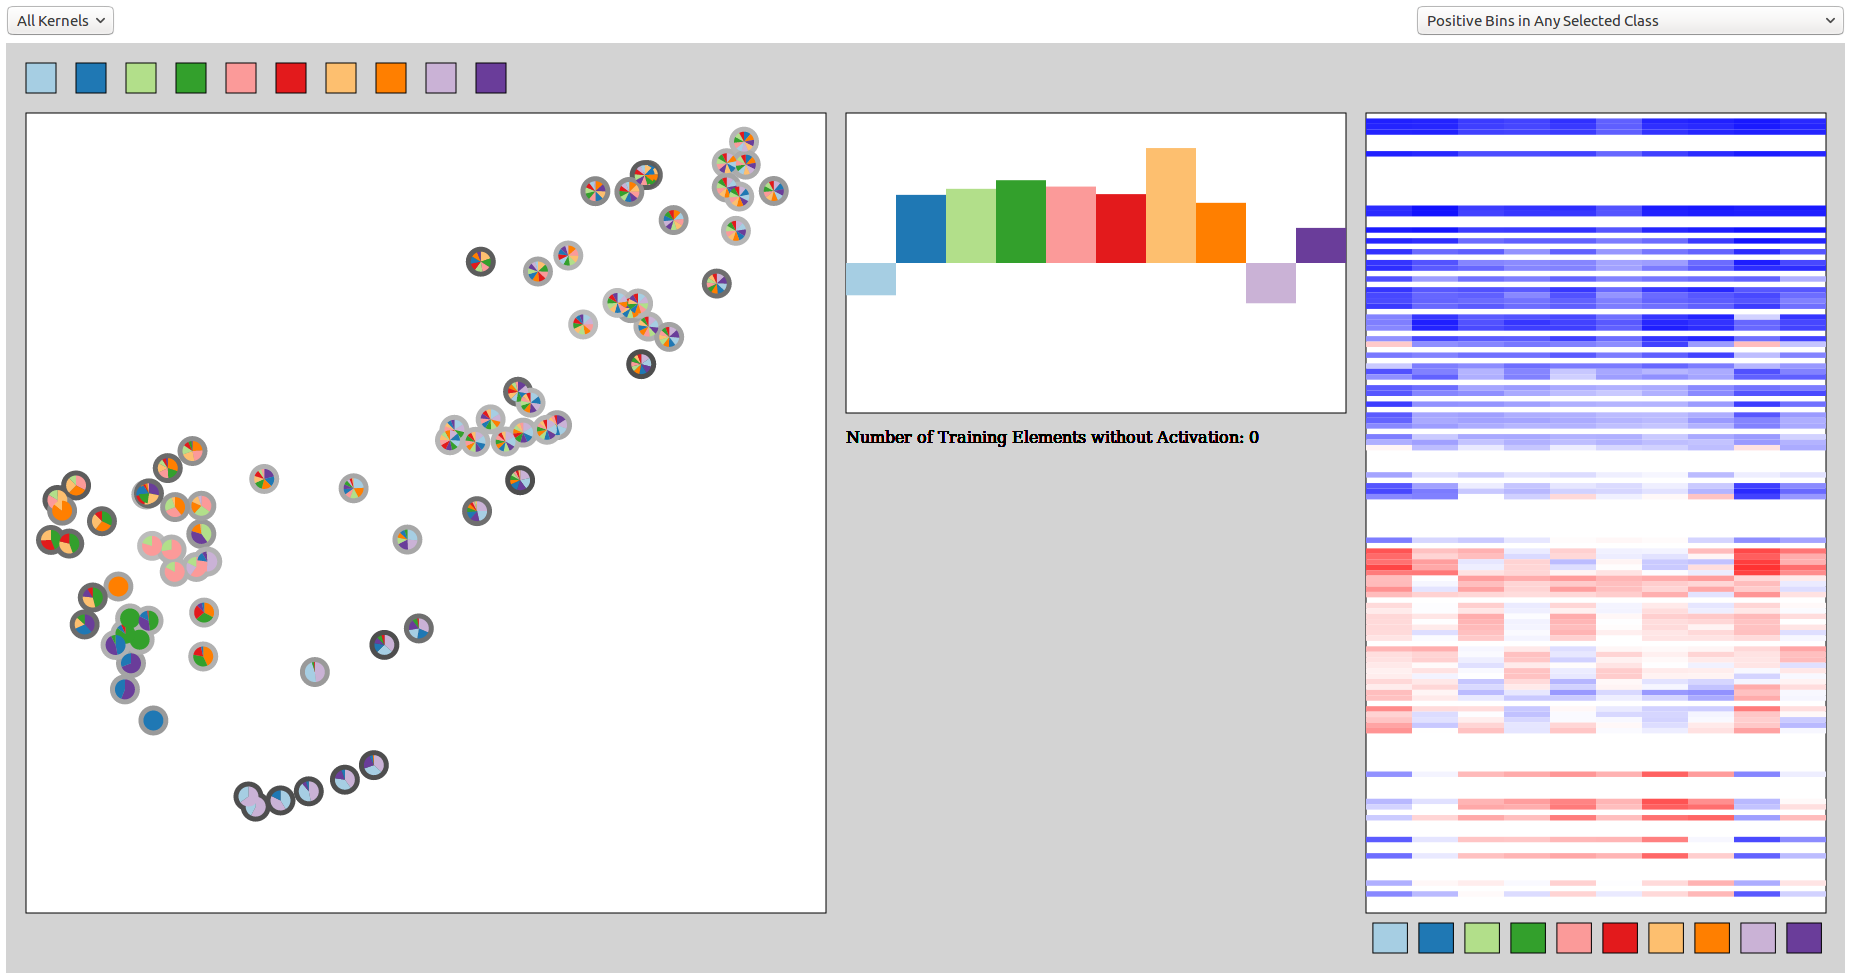

## 2nd Layer Analysis

In [441]:
histograms, selectivity = af.class_histogram_conv2d_v3(model, 1, x_train, t_labels, p_labels, num_classes)

In [442]:
actv_matrix = af.activation_matrix_conv2d(model, 1, x_train, t_labels, p_labels, num_classes)    

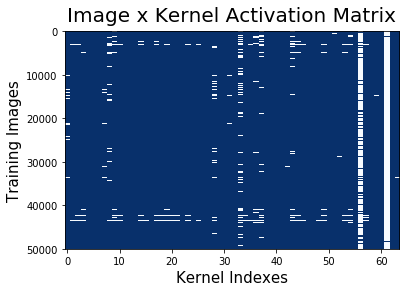

0

In [443]:
af.plot_activation_matrix(actv_matrix)

In [444]:
histograms.shape, selectivity.shape

((64, 32, 32, 10), (64, 32, 32, 10))

In [445]:
histograms = af.merge_pixels_dim(histograms)
selectivity = af.merge_pixels_dim(selectivity)

In [446]:
histograms.shape, selectivity.shape

((64, 1024, 10), (64, 1024, 10))

In [447]:
si_max, si_mean = af.selectivity_intensity(selectivity)
si_max.shape, si_mean.shape

((64,), (64,))

In [448]:
h, s = af.cluster_histograms(histograms, selectivity, 10)

In [449]:
h.shape, s.shape

((64, 10, 10), (64, 10, 10))

In [450]:
id_array = af.kernel_id_array(h)

In [451]:
h = af.merge_array_dim(h)
s = af.merge_array_dim(s)

In [452]:
h.shape, s.shape, id_array.shape

((640, 10), (640, 10), (640,))

In [467]:
h1, s1, m1, k1 = af.remove_histograms_by_selectivity(-1.0, 1.0, h, s, actv_matrix, id_array, num_classes)

In [468]:
h1.shape, s1.shape, k1.shape, m1.shape

((640, 10), (640, 10), (640,), (50000, 64))

In [469]:
np.unique(k1), np.unique(k1).shape

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]), (64,))

In [470]:
n_model = af.reduce_model_units(model, 1, np.unique(k1))

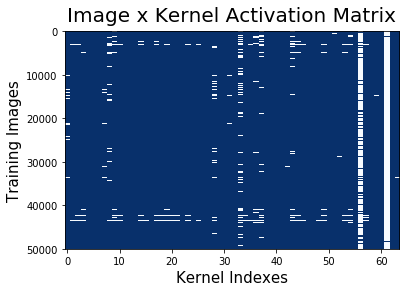

0

In [471]:
af.plot_activation_matrix(m1)

In [472]:
scores = n_model.evaluate(x_test, y_test, verbose=2)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 80.54%


In [473]:
proj, div = af.project_histogram(h1, p=30, e=12.0, l=200.0)
div

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 640 samples in 0.001s...
[t-SNE] Computed neighbors for 640 samples in 4.293s...
[t-SNE] Computed conditional probabilities for sample 640 / 640
[t-SNE] Mean sigma: 58.662468
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.587620
[t-SNE] Error after 1000 iterations: 0.523344


0.5233436226844788

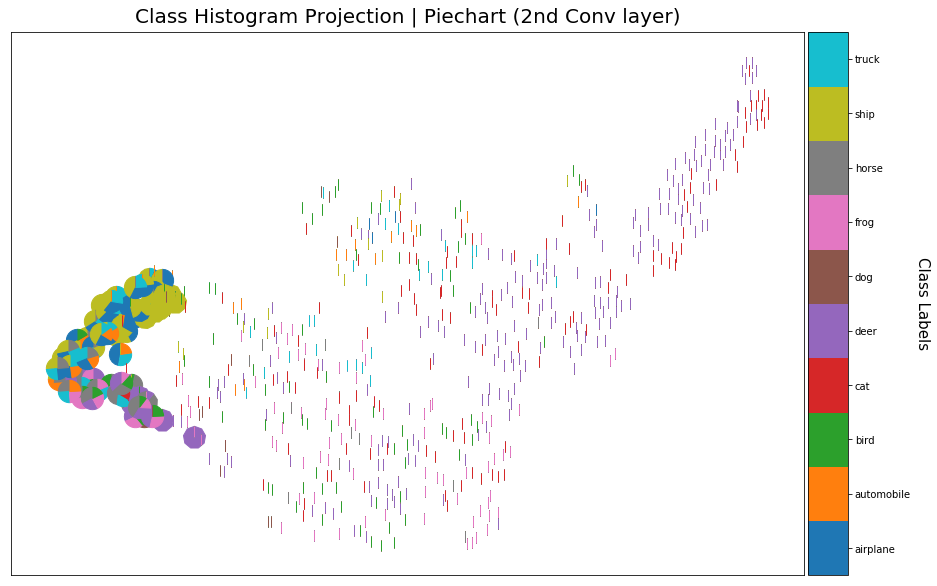

In [474]:
af.plot_projection_piechart(proj, h1, 4, labels, '2nd Conv', -1, 500)

In [475]:
h1.shape, s1.shape, k1.shape, proj.shape

((640, 10), (640, 10), (640,), (640, 2))

In [476]:
h1, s1, k1, proj = af.sort_histograms(h1, s1, k1, proj)

In [477]:
h1.shape, s1.shape, k1.shape, proj.shape

((640, 10), (640, 10), (640,), (640, 2))

In [478]:
h1, s1, o1 = af.sort_bins(h1, s1)

In [479]:
h1.shape, s1.shape, o1.shape

((640, 10), (640, 10), (640, 10))

In [480]:
data = {
    'histograms': h1.tolist(),
    'selectivity': s1.tolist(),
    'actv_matrix': m1.tolist(),
    'id_array': k1.tolist(),
    'bin_order': o1.tolist(),
    'projection': proj.tolist(),
    'intensity_max': si_max.tolist(),
    'intensity_mean': si_mean.tolist()
}

with open('refinement_v2/layer2.json', 'w') as fp:
    json.dump(data, fp)

## 3th Layer Analysis

In [483]:
histograms, selectivity = af.class_histogram_conv2d_v3(model, 4, x_train, t_labels, p_labels, num_classes)

In [484]:
actv_matrix = af.activation_matrix_conv2d(model, 4, x_train, t_labels, p_labels, num_classes)    

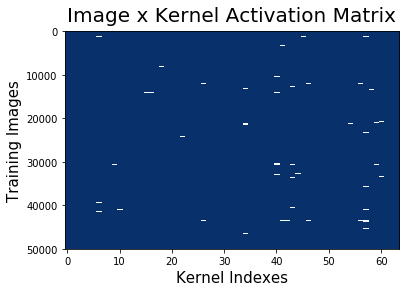

0

In [485]:
af.plot_activation_matrix(actv_matrix)

In [486]:
histograms.shape, selectivity.shape

((64, 16, 16, 10), (64, 16, 16, 10))

In [487]:
histograms = af.merge_pixels_dim(histograms)
selectivity = af.merge_pixels_dim(selectivity)

In [488]:
histograms.shape, selectivity.shape

((64, 256, 10), (64, 256, 10))

In [489]:
si_max, si_mean = af.selectivity_intensity(selectivity)
si_max.shape, si_mean.shape

((64,), (64,))

In [490]:
h, s = af.cluster_histograms(histograms, selectivity, 10)

In [491]:
h.shape, s.shape

((64, 10, 10), (64, 10, 10))

In [492]:
id_array = af.kernel_id_array(h)

In [493]:
h = af.merge_array_dim(h)
s = af.merge_array_dim(s)

In [494]:
h.shape, s.shape, id_array.shape

((640, 10), (640, 10), (640,))

In [495]:
h1, s1, m1, k1 = af.remove_histograms_by_selectivity(-1.0, 1.0, h, s, actv_matrix, id_array, num_classes)

In [496]:
h1.shape, s1.shape, k1.shape, m1.shape

((640, 10), (640, 10), (640,), (50000, 64))

In [497]:
np.unique(k1), np.unique(k1).shape

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]), (64,))

In [498]:
n_model = af.reduce_model_units(model, 4, np.unique(k1))

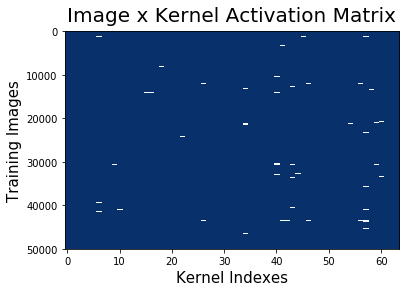

0

In [499]:
af.plot_activation_matrix(m1)

In [500]:
scores = n_model.evaluate(x_test, y_test, verbose=2)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 80.54%


In [501]:
proj, div = af.project_histogram(h1, p=30, e=12.0, l=200.0)
div

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 640 samples in 0.060s...
[t-SNE] Computed neighbors for 640 samples in 0.119s...
[t-SNE] Computed conditional probabilities for sample 640 / 640
[t-SNE] Mean sigma: 384.155364
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.556511
[t-SNE] Error after 1000 iterations: 0.640560


0.6405599117279053

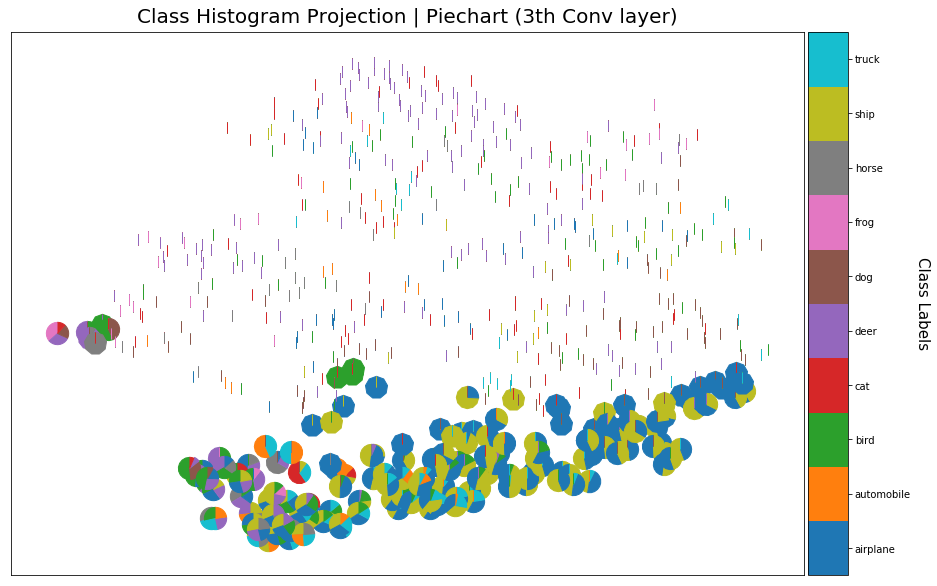

In [502]:
af.plot_projection_piechart(proj, h1, 4, labels, '3th Conv', -1, 500)

In [503]:
h1.shape, s1.shape, k1.shape, proj.shape

((640, 10), (640, 10), (640,), (640, 2))

In [504]:
h1, s1, k1, proj = af.sort_histograms(h1, s1, k1, proj)

In [505]:
h1.shape, s1.shape, k1.shape, proj.shape

((640, 10), (640, 10), (640,), (640, 2))

In [506]:
h1, s1, o1 = af.sort_bins(h1, s1)

In [507]:
h1.shape, s1.shape, o1.shape

((640, 10), (640, 10), (640, 10))

In [508]:
data = {
    'histograms': h1.tolist(),
    'selectivity': s1.tolist(),
    'actv_matrix': m1.tolist(),
    'id_array': k1.tolist(),
    'bin_order': o1.tolist(),
    'projection': proj.tolist(),
    'intensity_max': si_max.tolist(),
    'intensity_mean': si_mean.tolist()
}

with open('refinement_v2/layer3.json', 'w') as fp:
    json.dump(data, fp)

## 4th Layer Analysis

In [510]:
histograms, selectivity = af.class_histogram_conv2d_v3(model, 5, x_train, t_labels, p_labels, num_classes)

In [511]:
actv_matrix = af.activation_matrix_conv2d(model, 5, x_train, t_labels, p_labels, num_classes)    

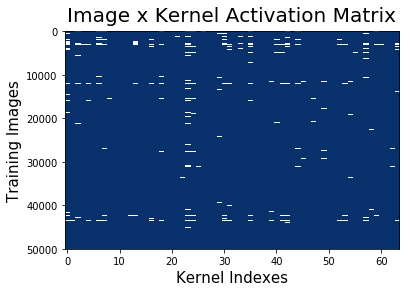

0

In [512]:
af.plot_activation_matrix(actv_matrix)

In [513]:
histograms.shape, selectivity.shape

((64, 16, 16, 10), (64, 16, 16, 10))

In [514]:
histograms = af.merge_pixels_dim(histograms)
selectivity = af.merge_pixels_dim(selectivity)

In [515]:
histograms.shape, selectivity.shape

((64, 256, 10), (64, 256, 10))

In [516]:
si_max, si_mean = af.selectivity_intensity(selectivity)
si_max.shape, si_mean.shape

((64,), (64,))

In [517]:
h, s = af.cluster_histograms(histograms, selectivity, 10)

In [518]:
h.shape, s.shape

((64, 10, 10), (64, 10, 10))

In [519]:
id_array = af.kernel_id_array(h)

In [520]:
h = af.merge_array_dim(h)
s = af.merge_array_dim(s)

In [521]:
h.shape, s.shape, id_array.shape

((640, 10), (640, 10), (640,))

In [522]:
h1, s1, m1, k1 = af.remove_histograms_by_selectivity(-1.0, 1.0, h, s, actv_matrix, id_array, num_classes)

In [523]:
h1.shape, s1.shape, k1.shape, m1.shape

((640, 10), (640, 10), (640,), (50000, 64))

In [524]:
np.unique(k1), np.unique(k1).shape

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]), (64,))

In [525]:
n_model = af.reduce_model_units(model, 5, np.unique(k1))

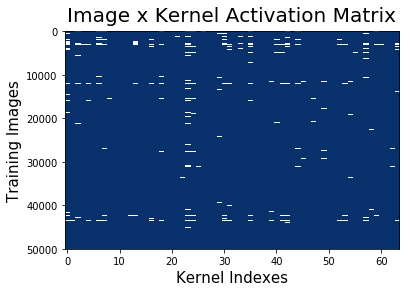

0

In [526]:
af.plot_activation_matrix(m1)

In [527]:
scores = n_model.evaluate(x_test, y_test, verbose=2)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 80.54%


In [528]:
proj, div = af.project_histogram(h1, p=30, e=12.0, l=200.0)
div

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 640 samples in 0.071s...
[t-SNE] Computed neighbors for 640 samples in 0.266s...
[t-SNE] Computed conditional probabilities for sample 640 / 640
[t-SNE] Mean sigma: 207.627643
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.775681
[t-SNE] Error after 1000 iterations: 0.792030


0.7920302748680115

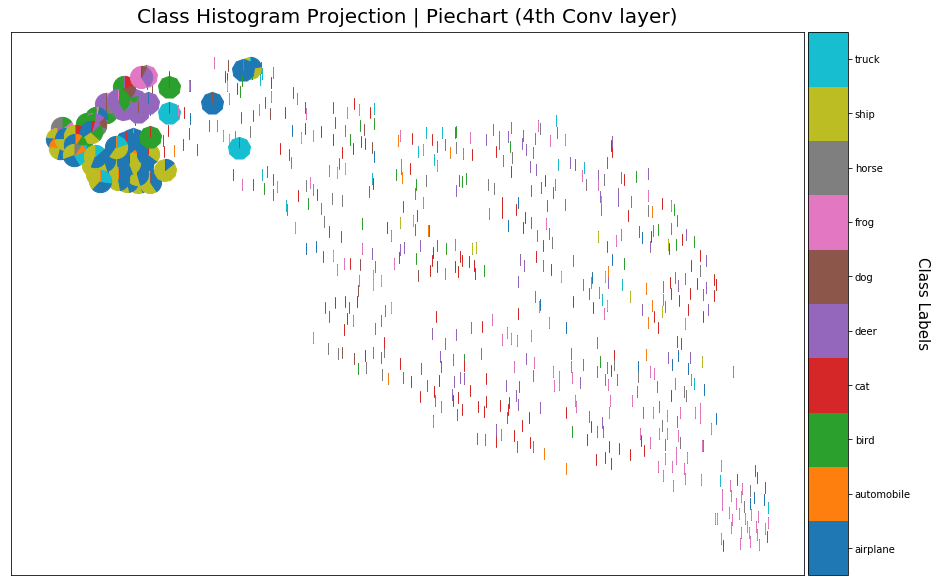

In [529]:
af.plot_projection_piechart(proj, h1, 5, labels, '4th Conv', -1, 500)

In [530]:
h1.shape, s1.shape, k1.shape, proj.shape

((640, 10), (640, 10), (640,), (640, 2))

In [531]:
h1, s1, k1, proj = af.sort_histograms(h1, s1, k1, proj)

In [532]:
h1.shape, s1.shape, k1.shape, proj.shape

((640, 10), (640, 10), (640,), (640, 2))

In [533]:
h1, s1, o1 = af.sort_bins(h1, s1)

In [534]:
h1.shape, s1.shape, o1.shape

((640, 10), (640, 10), (640, 10))

In [535]:
data = {
    'histograms': h1.tolist(),
    'selectivity': s1.tolist(),
    'actv_matrix': m1.tolist(),
    'id_array': k1.tolist(),
    'bin_order': o1.tolist(),
    'projection': proj.tolist(),
    'intensity_max': si_max.tolist(),
    'intensity_mean': si_mean.tolist()
}

with open('refinement_v2/layer4.json', 'w') as fp:
    json.dump(data, fp)

## 5th Layer Analysis

In [536]:
histograms, selectivity = af.class_histogram_conv2d_v3(model, 8, x_train, t_labels, p_labels, num_classes)

In [537]:
actv_matrix = af.activation_matrix_conv2d(model, 8, x_train, t_labels, p_labels, num_classes)    

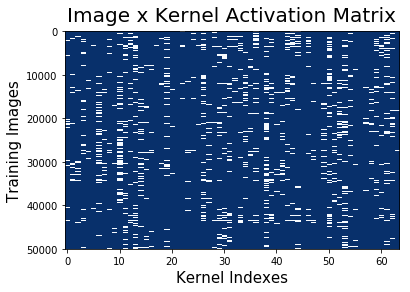

0

In [538]:
af.plot_activation_matrix(actv_matrix)

In [539]:
histograms.shape, selectivity.shape

((64, 8, 8, 10), (64, 8, 8, 10))

In [540]:
histograms = af.merge_pixels_dim(histograms)
selectivity = af.merge_pixels_dim(selectivity)

In [541]:
histograms.shape, selectivity.shape

((64, 64, 10), (64, 64, 10))

In [542]:
si_max, si_mean = af.selectivity_intensity(selectivity)
si_max.shape, si_mean.shape

((64,), (64,))

In [543]:
h, s = af.cluster_histograms(histograms, selectivity, 10)

In [544]:
h.shape, s.shape

((64, 10, 10), (64, 10, 10))

In [545]:
id_array = af.kernel_id_array(h)

In [546]:
h = af.merge_array_dim(h)
s = af.merge_array_dim(s)

In [547]:
h.shape, s.shape, id_array.shape

((640, 10), (640, 10), (640,))

In [548]:
h1, s1, m1, k1 = af.remove_histograms_by_selectivity(-1.0, 1.0, h, s, actv_matrix, id_array, num_classes)

In [549]:
h1.shape, s1.shape, k1.shape, m1.shape

((640, 10), (640, 10), (640,), (50000, 64))

In [550]:
np.unique(k1), np.unique(k1).shape

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]), (64,))

In [551]:
n_model = af.reduce_model_units(model, 8, np.unique(k1))

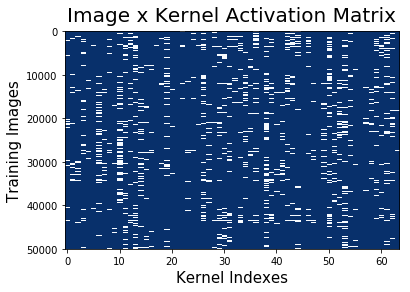

0

In [552]:
af.plot_activation_matrix(m1)

In [553]:
scores = n_model.evaluate(x_test, y_test, verbose=2)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 80.54%


In [554]:
proj, div = af.project_histogram(h1, p=30, e=12.0, l=200.0)
div

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 640 samples in 0.004s...
[t-SNE] Computed neighbors for 640 samples in 0.042s...
[t-SNE] Computed conditional probabilities for sample 640 / 640
[t-SNE] Mean sigma: 501.157348
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.477325
[t-SNE] Error after 1000 iterations: 0.900989


0.9009894132614136

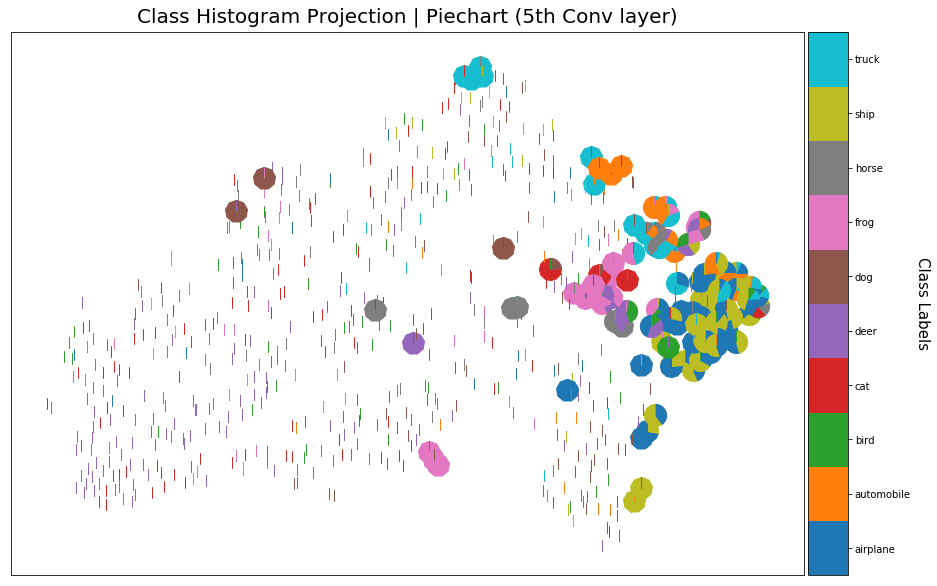

In [555]:
af.plot_projection_piechart(proj, h1, 4, labels, '5th Conv', -1, 500)

In [556]:
h1.shape, s1.shape, k1.shape, proj.shape

((640, 10), (640, 10), (640,), (640, 2))

In [557]:
h1, s1, k1, proj = af.sort_histograms(h1, s1, k1, proj)

In [558]:
h1.shape, s1.shape, k1.shape, proj.shape

((640, 10), (640, 10), (640,), (640, 2))

In [559]:
h1, s1, o1 = af.sort_bins(h1, s1)

In [560]:
h1.shape, s1.shape, o1.shape

((640, 10), (640, 10), (640, 10))

In [561]:
data = {
    'histograms': h1.tolist(),
    'selectivity': s1.tolist(),
    'actv_matrix': m1.tolist(),
    'id_array': k1.tolist(),
    'bin_order': o1.tolist(),
    'projection': proj.tolist(),
    'intensity_max': si_max.tolist(),
    'intensity_mean': si_mean.tolist()
}

with open('refinement_v2/layer5.json', 'w') as fp:
    json.dump(data, fp)

## 6th Layer Analysis

In [562]:
histograms, selectivity = af.class_histogram_conv2d_v3(model, 9, x_train, t_labels, p_labels, num_classes)

In [563]:
actv_matrix = af.activation_matrix_conv2d(model, 9, x_train, t_labels, p_labels, num_classes)    

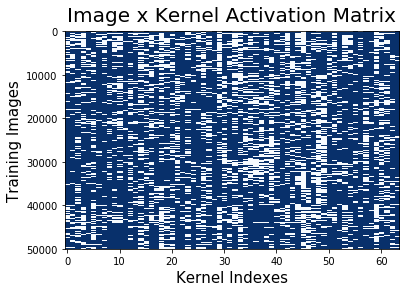

0

In [564]:
af.plot_activation_matrix(actv_matrix)

In [565]:
histograms.shape, selectivity.shape

((64, 8, 8, 10), (64, 8, 8, 10))

In [566]:
histograms = af.merge_pixels_dim(histograms)
selectivity = af.merge_pixels_dim(selectivity)

In [567]:
histograms.shape, selectivity.shape

((64, 64, 10), (64, 64, 10))

In [568]:
si_max, si_mean = af.selectivity_intensity(selectivity)
si_max.shape, si_mean.shape

((64,), (64,))

In [569]:
h, s = af.cluster_histograms(histograms, selectivity, 10)

In [570]:
h.shape, s.shape

((64, 10, 10), (64, 10, 10))

In [571]:
id_array = af.kernel_id_array(h)

In [572]:
h = af.merge_array_dim(h)
s = af.merge_array_dim(s)

In [573]:
h.shape, s.shape, id_array.shape

((640, 10), (640, 10), (640,))

In [574]:
h1, s1, m1, k1 = af.remove_histograms_by_selectivity(-1.0, 1.0, h, s, actv_matrix, id_array, num_classes)

In [575]:
h1.shape, s1.shape, k1.shape, m1.shape

((640, 10), (640, 10), (640,), (50000, 64))

In [576]:
np.unique(k1), np.unique(k1).shape

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]), (64,))

In [577]:
n_model = af.reduce_model_units(model, 9, np.unique(k1))

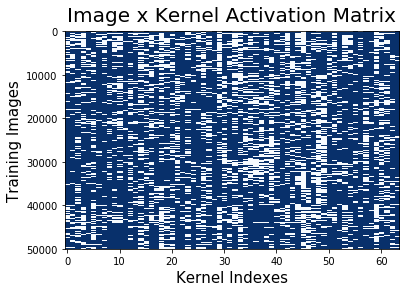

0

In [578]:
af.plot_activation_matrix(m1)

In [579]:
scores = n_model.evaluate(x_test, y_test, verbose=2)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 80.54%


In [580]:
proj, div = af.project_histogram(h1, p=30, e=12.0, l=200.0)
div

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 640 samples in 0.000s...
[t-SNE] Computed neighbors for 640 samples in 0.019s...
[t-SNE] Computed conditional probabilities for sample 640 / 640
[t-SNE] Mean sigma: 408.473339
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.065399
[t-SNE] Error after 1000 iterations: 0.773524


0.7735236287117004

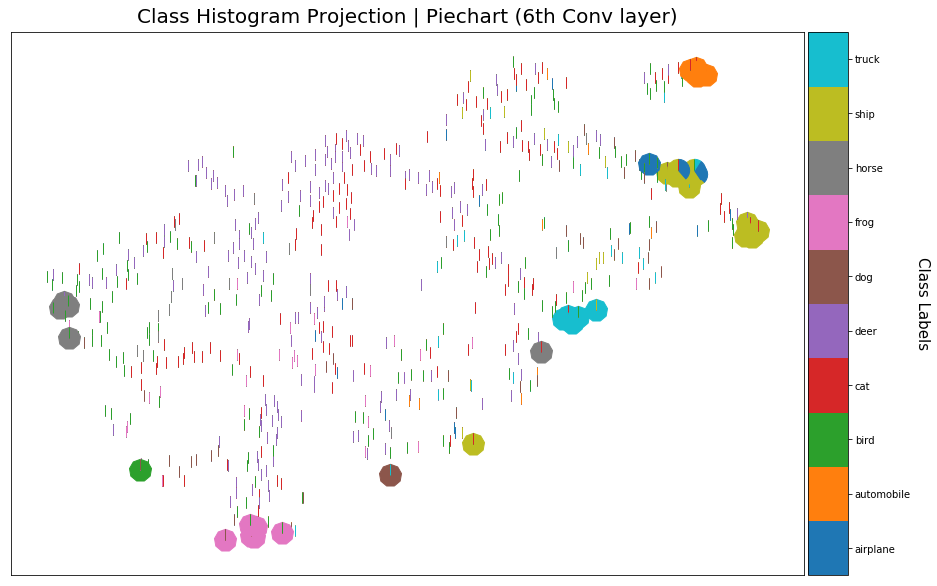

In [581]:
af.plot_projection_piechart(proj, h1, 4, labels, '6th Conv', -1, 500)

In [582]:
h1.shape, s1.shape, k1.shape, proj.shape

((640, 10), (640, 10), (640,), (640, 2))

In [583]:
h1, s1, k1, proj = af.sort_histograms(h1, s1, k1, proj)

In [584]:
h1.shape, s1.shape, k1.shape, proj.shape

((640, 10), (640, 10), (640,), (640, 2))

In [585]:
h1, s1, o1 = af.sort_bins(h1, s1)

In [586]:
h1.shape, s1.shape, o1.shape

((640, 10), (640, 10), (640, 10))

In [587]:
data = {
    'histograms': h1.tolist(),
    'selectivity': s1.tolist(),
    'actv_matrix': m1.tolist(),
    'id_array': k1.tolist(),
    'bin_order': o1.tolist(),
    'projection': proj.tolist(),
    'intensity_max': si_max.tolist(),
    'intensity_mean': si_mean.tolist()
}

with open('refinement_v2/layer6.json', 'w') as fp:
    json.dump(data, fp)